##Installations and Imports

In [ ]:
!pip install pyedflib

In [2]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [3]:
from tensorflow.keras import layers, models, optimizers, callbacks
import tensorflow_probability as tfp
from tensorflow.keras.metrics import AUC, Recall, Precision

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EEGET-ALS Dataset

Loading Dataset (w/o Drive)

In [4]:
!curl -L -O https://springernature.figshare.com/ndownloader/files/46933189

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1602M  100 1602M    0     0  17.7M      0  0:01:30  0:01:30 --:--:-- 18.6M


In [5]:
!unzip 46933189

Streaming output truncated to the last 5000 lines.
  inflating: EEGET-ALS Dataset/id2/time1/scenario3/EEG.edf  
  inflating: EEGET-ALS Dataset/id2/time1/scenario3/eeg.json  
  inflating: EEGET-ALS Dataset/id2/time1/scenario3/EEGTimeStamp.txt  
  inflating: EEGET-ALS Dataset/id2/time1/scenario3/ET.csv  
  inflating: EEGET-ALS Dataset/id2/time1/scenario3/scenario.json  
   creating: EEGET-ALS Dataset/id2/time1/scenario4/
  inflating: EEGET-ALS Dataset/id2/time1/scenario4/EEG.edf  
  inflating: EEGET-ALS Dataset/id2/time1/scenario4/eeg.json  
  inflating: EEGET-ALS Dataset/id2/time1/scenario4/EEGTimeStamp.txt  
  inflating: EEGET-ALS Dataset/id2/time1/scenario4/ET.csv  
  inflating: EEGET-ALS Dataset/id2/time1/scenario4/scenario.json  
   creating: EEGET-ALS Dataset/id2/time1/scenario5/
  inflating: EEGET-ALS Dataset/id2/time1/scenario5/EEG.edf  
  inflating: EEGET-ALS Dataset/id2/time1/scenario5/eeg.json  
  inflating: EEGET-ALS Dataset/id2/time1/scenario5/EEGTimeStamp.txt  
  inflating:

In [6]:
def read_edf_file(file_path):
    f = pyedflib.EdfReader(file_path)
    num_signals = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sample_frequencies = f.getSampleFrequencies()
    signals = []
    for i in range(num_signals):
        signal = f.readSignal(i)
        signals.append(signal)
    f.close()
    return signal_labels, sample_frequencies, signals

In [7]:
list_of_eegs, list_of_labels = [], []
for folder in os.listdir('/content/EEGET-ALS Dataset'):
  if folder[:2] == "id":
    for scenario in os.listdir(os.path.join('/content/EEGET-ALS Dataset', folder, "time1")):
      if scenario[:8] == "scenario":
        for file in os.listdir(os.path.join('/content/EEGET-ALS Dataset', folder, "time1", scenario)):
          if file.endswith('.edf'):
            signal_labels, sample_frequencies, eeg_signals = read_edf_file(os.path.join('/content/EEGET-ALS Dataset', folder, "time1", scenario, file))
            list_of_eegs.append(np.array(eeg_signals))
            list_of_labels.append(1)
  elif folder[:3] == "ALS":
    for time in os.listdir(os.path.join('/content/EEGET-ALS Dataset', folder)):
      if time[:4] == "time":
        for scenario in os.listdir(os.path.join('/content/EEGET-ALS Dataset', folder, time)):
          if scenario[:8] == "scenario":
            for file in os.listdir(os.path.join('/content/EEGET-ALS Dataset', folder, time, scenario)):
              if file.endswith('.edf'):
                signal_labels, sample_frequencies, eeg_signals = read_edf_file(os.path.join('/content/EEGET-ALS Dataset', folder, time, scenario, file))
                list_of_eegs.append(np.array(eeg_signals))
                list_of_labels.append(0)

In [8]:
def find_percent_between(arr, min_val, max_val):
    return (sum(min_val <= itm.shape[1] <= max_val for itm in arr) / len(arr)) * 100

In [9]:
def plot_eeg_data(signal_labels, sample_frequencies, signals):
    plt.figure(figsize=(15, 10))
    for i, (label, freq, data) in enumerate(zip(signal_labels, sample_frequencies, signals)):
        time_points = np.arange(0, len(data)) / freq
        plt.subplot(len(signal_labels), 1, i + 1)
        plt.plot(time_points, data)
        plt.title(label)
    plt.tight_layout()
    plt.show()

In [10]:
def resize_eegs(arr, target_shape):
  tmp = []
  for lst in range(arr.shape[0]):
    tmp.append(np.resize(arr[lst], target_shape))
  return np.array(tmp)

In [11]:
tmp = []
for arr in list_of_eegs:
  tmp.append(resize_eegs(arr, 120 * 128))
list_of_eegs = np.array(tmp)

<ipython-input-9-95f328644d17>:8: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


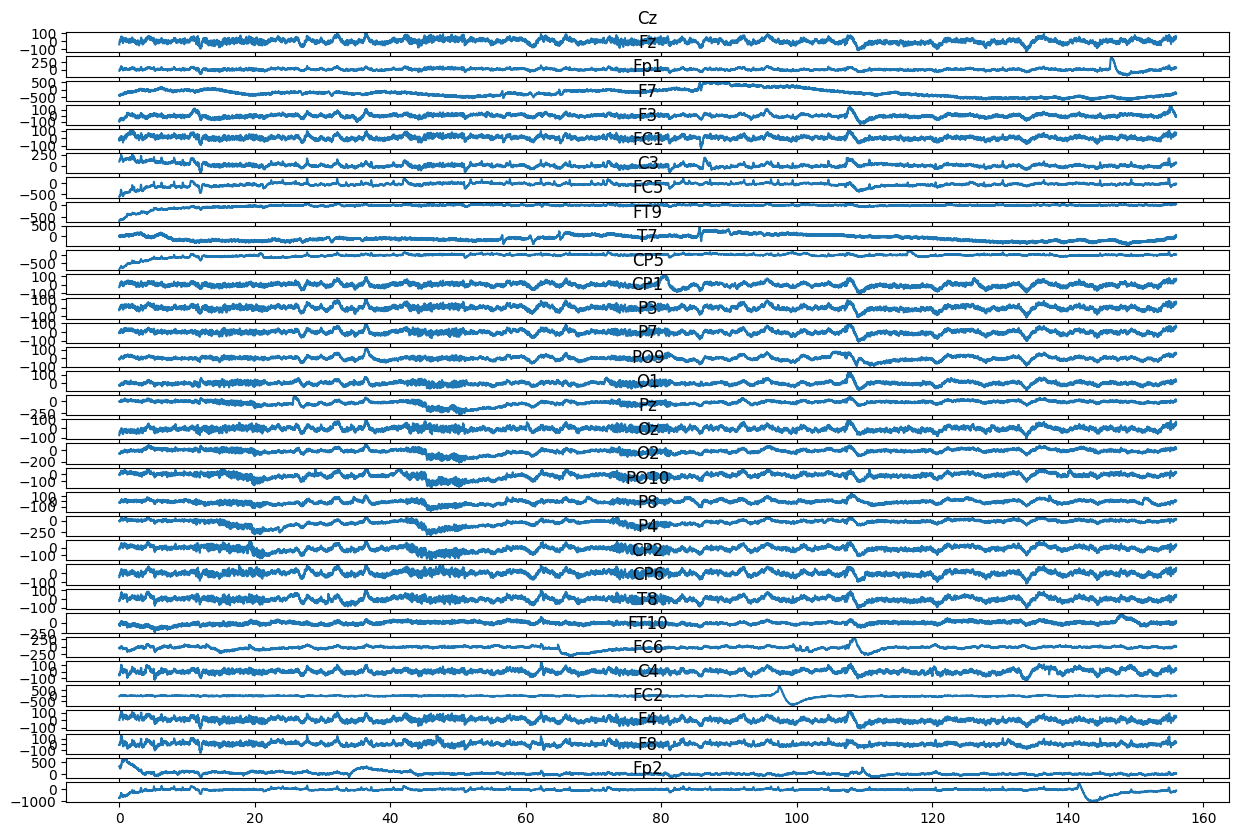

In [12]:
plot_eeg_data(signal_labels, sample_frequencies, eeg_signals)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((list_of_eegs, list_of_labels))

In [14]:
dataset.save("/content/drive/MyDrive/ALS Diagnosis Project/Dataset")

Loading Dataset (w/ Drive)

In [5]:
dataset = tf.data.Dataset.load("/content/drive/MyDrive/ALS Diagnosis Project/Dataset")

## Generating Train/Validation/Test Data

In [15]:
def generate_train_test_val_splits(dataset,train_size,test_size,val_size):
  train_size = int(len(dataset)*train_size)
  test_size = int(len(dataset)*test_size)
  val_size = int(len(dataset)*val_size)
  dataset = dataset.shuffle(len(dataset))
  train_dataset = dataset.take(train_size)
  test_dataset = dataset.skip(train_size).take(test_size)
  val_dataset = dataset.skip(train_size+test_size).take(val_size)
  return train_dataset,test_dataset,val_dataset

In [16]:
train_ds, test_ds, val_ds = generate_train_test_val_splits(dataset, 0.7, 0.15, 0.15)

In [17]:
batch_size = 16
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

## Training and Evaluating Model

In [18]:
input_seq = layers.Input(shape=(32, 120 * 128))

# Transformer Layer 1
x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(input_seq, input_seq)
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.Dense(64, activation='relu')(x)

# Transformer Layer 2
x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.Dense(128, activation='relu')(x)

# Transformer Layer 3
x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.Dense(256, activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=input_seq, outputs=output)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       AUC(),
                       Precision(),
                       Recall()]
)

learning_rate_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 15360)]          0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 32, 15360)            1574476   ['input_1[0][0]',             
 iHeadAttention)                                          8          'input_1[0][0]']             
                                                                                                  
 layer_normalization (Layer  (None, 32, 15360)            30720     ['multi_head_attention[0][0]']
 Normalization)                                                                                   
                                                                                              

In [21]:
import time
start_time = time.process_time()
history = model.fit(train_ds, epochs=70, validation_data=val_ds, callbacks=[learning_rate_scheduler])
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(test_ds)

print()
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test AUC:", test_auc)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

print()
total_time = time.process_time() - start_time
print("Time taken:", total_time)

Epoch 1/70
87/87 [==============================] - 16s 55ms/step - loss: 0.6624 - accuracy: 0.6336 - auc: 0.6862 - precision: 0.8562 - recall: 0.6316 - val_loss: 0.6948 - val_accuracy: 0.5537 - val_auc: 0.8471 - val_precision: 0.9780 - val_recall: 0.4045 - lr: 1.0000e-04
Epoch 2/70
87/87 [==============================] - 3s 35ms/step - loss: 0.6418 - accuracy: 0.6336 - auc: 0.6975 - precision: 0.8738 - recall: 0.6132 - val_loss: 0.5519 - val_accuracy: 0.7282 - val_auc: 0.7508 - val_precision: 0.8867 - val_recall: 0.7563 - lr: 1.0000e-04
Epoch 3/70
87/87 [==============================] - 3s 35ms/step - loss: 0.6129 - accuracy: 0.6897 - auc: 0.7314 - precision: 0.8763 - recall: 0.6999 - val_loss: 2.7694 - val_accuracy: 0.2315 - val_auc: 0.7820 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/70
87/87 [==============================] - 3s 35ms/step - loss: 0.5864 - accuracy: 0.7313 - auc: 0.7450 - precision: 0.8708 - recall: 0.7654 - val_loss: 0.9746 - val_

## Displaying Results

In [22]:
def create_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(len(acc))
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.savefig('/content/accuracy.png')
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig('/content/loss.png')
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, auc, 'bo-', label='Training AUC')
    plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()
    plt.savefig('/content/auc.png')
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, precision, 'bo-', label='Training Precision')
    plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    plt.savefig('/content/precision.png')
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, recall, 'bo-', label='Training Recall')
    plt.plot(epochs, val_recall, 'ro-', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()
    plt.savefig('/content/recall.png')

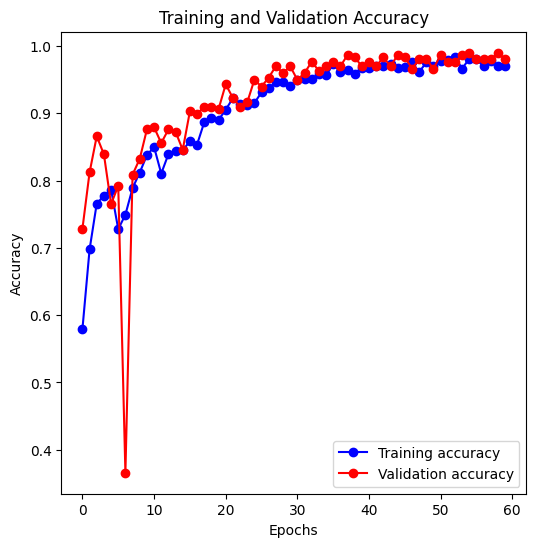

<Figure size 640x480 with 0 Axes>

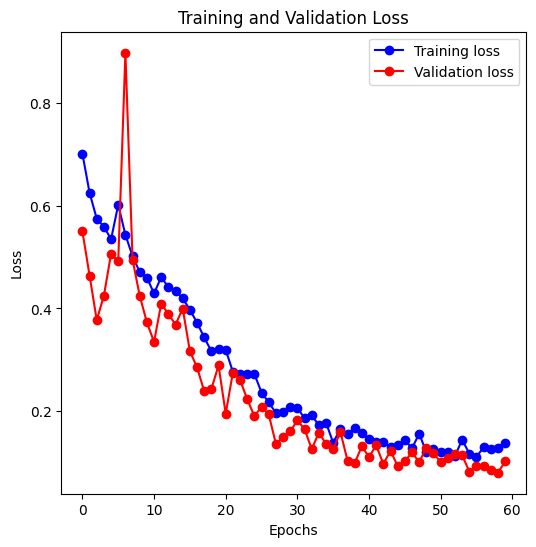

<Figure size 640x480 with 0 Axes>

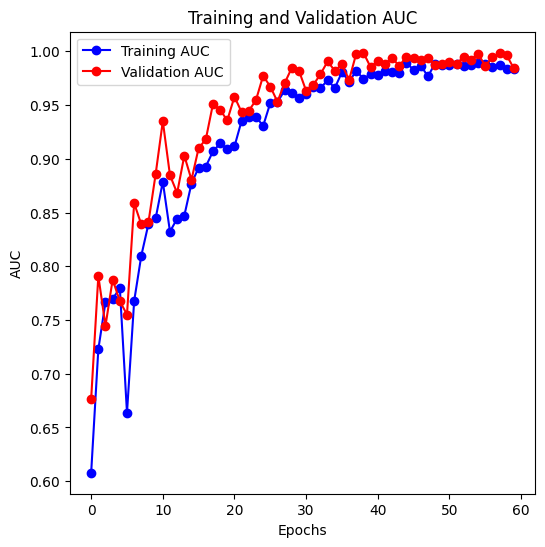

<Figure size 640x480 with 0 Axes>

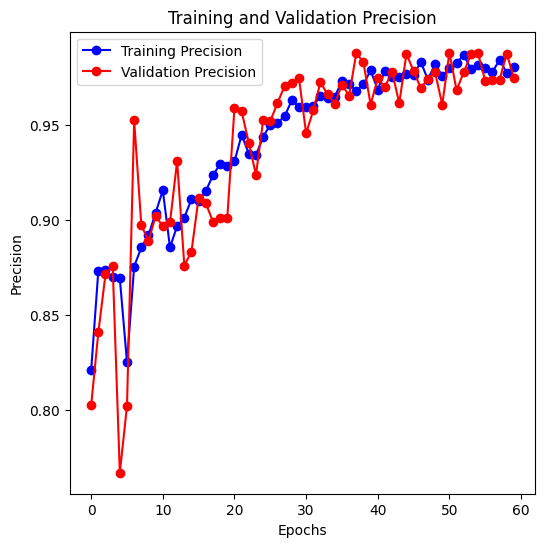

<Figure size 640x480 with 0 Axes>

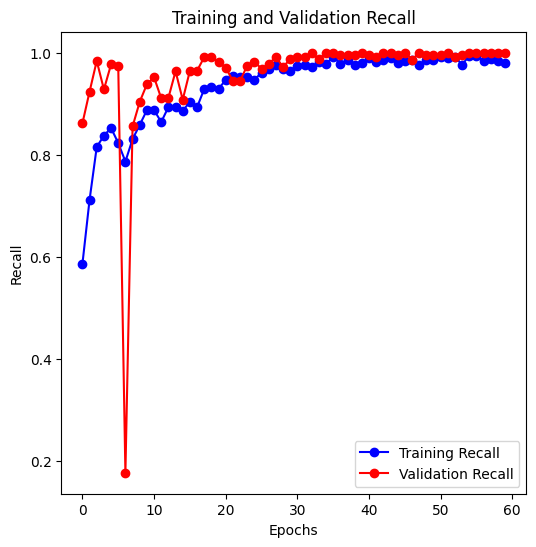

<Figure size 640x480 with 0 Axes>

In [ ]:
create_plot(history)

In [23]:
model.save('/content/drive/MyDrive/ALS Diagnosis Project/als_model.keras')

In [ ]:
import shutil
shutil.copy("/content/accuracy.png", "/content/drive/MyDrive/ALS Diagnosis Project")
shutil.copy("/content/auc.png", "/content/drive/MyDrive/ALS Diagnosis Project")
shutil.copy("/content/loss.png", "/content/drive/MyDrive/ALS Diagnosis Project")
shutil.copy("/content/precision.png", "/content/drive/MyDrive/ALS Diagnosis Project")
shutil.copy("/content/recall.png", "/content/drive/MyDrive/ALS Diagnosis Project")

'/content/drive/MyDrive/ALS Diagnosis Project/recall.png'